## load spark session

In [1]:
spark

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 6, Finished, Available)

### Import all necessary packages

In [26]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from tqdm import tqdm
import re
# Import NLTK and WordNetLemmatizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 31, Finished, Available)

### load the external data

In [7]:
data_pd = pd.read_csv("Users/xl659/fall-2023-reddit-project-team-10/data/csv/mbti_1.csv")

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 12, Finished, Available)

In [35]:
data = spark.createDataFrame(data_pd)

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 40, Finished, Available)

In [36]:
data.show(5)

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 41, Finished, Available)

+----+--------------------+
|type|               posts|
+----+--------------------+
|INFJ|'http://www.youtu...|
|ENTP|'I'm finding the ...|
|INTP|'Good one  _____ ...|
|INTJ|'Dear INTP,   I e...|
|ENTJ|'You're fired.|||...|
+----+--------------------+
only showing top 5 rows



## data preprocessing

In [37]:
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer
from pyspark.ml import Pipeline

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 42, Finished, Available)

In [38]:
#convert to lower case
df_cleaned = data.withColumn("cleaned_text", lower(col("posts")))
# remove punctuation
df_cleaned = df_cleaned.withColumn("cleaned_text", regexp_replace("cleaned_text", "[^a-zA-Z0-9\\s]", ""))
# remove the rows with na in the cleaned_text column
df_cleaned = df_cleaned.na.drop(subset=["cleaned_text"])

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 43, Finished, Available)

In [39]:
df_cleaned.show(5)

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 44, Finished, Available)

+----+--------------------+--------------------+
|type|               posts|        cleaned_text|
+----+--------------------+--------------------+
|INFJ|'http://www.youtu...|httpwwwyoutubecom...|
|ENTP|'I'm finding the ...|im finding the la...|
|INTP|'Good one  _____ ...|good one     http...|
|INTJ|'Dear INTP,   I e...|dear intp   i enj...|
|ENTJ|'You're fired.|||...|youre firedthats ...|
+----+--------------------+--------------------+
only showing top 5 rows



## build ML models to classify the posts

In [58]:
#load all the packages
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.sql.functions import regexp_replace, col
from pyspark.ml.feature import Tokenizer, CountVectorizer
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import Row

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 63, Finished, Available)

## Build Model Pipeline

In [43]:
# Tokenize and Vectorize Text
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="tokens")
vectorizer = CountVectorizer(inputCol="tokens", outputCol="features")

#  Convert the "type" column to a numeric type
indexer = StringIndexer(inputCol="type", outputCol="label")

# Split Data into Train, Test, and Validation Sets
# Adjust the ratios based on your preference
train_df, test_df, val_df = df_cleaned.randomSplit([0.8, 0.1, 0.1], seed=42)


StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 48, Finished, Available)

#### Logistic Regression Classifier

In [56]:
# Logistic Regression Classifier
lr = LogisticRegression(labelCol="label", featuresCol="features")
lr_pipeline = Pipeline(stages=[tokenizer, vectorizer,indexer, lr])
lr_model = lr_pipeline.fit(train_df)

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 61, Finished, Available)

#### Support Vector Classifier

In [59]:
lsvc = LinearSVC(maxIter=10)
ovr = OneVsRest(classifier=lsvc, labelCol="label", featuresCol="features")
ovr_pipeline = Pipeline(stages=[tokenizer, vectorizer, indexer, ovr])
ovr_model = ovr_pipeline.fit(train_df)

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 64, Finished, Available)

#### Random Forest

In [50]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rf_pipeline = Pipeline(stages=[tokenizer, vectorizer, indexer, rf])
rf_model = rf_pipeline.fit(train_df)


StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 55, Finished, Available)

#### evaluate the model

In [47]:
# Evaluate the Models
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")


StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 52, Finished, Available)

In [60]:
# Evaluate Logistic Regression model
lr_test_predictions = lr_model.transform(test_df)
lr_val_predictions = lr_model.transform(val_df)
lr_test_accuracy = evaluator.evaluate(lr_test_predictions)
lr_test_f1_score = f1_evaluator.evaluate(lr_test_predictions)
lr_test_precision = precision_evaluator.evaluate(lr_test_predictions)
lr_test_recall = recall_evaluator.evaluate(lr_test_predictions)

lr_val_accuracy = evaluator.evaluate(lr_val_predictions)
lr_val_f1_score = f1_evaluator.evaluate(lr_val_predictions)
lr_val_precision = precision_evaluator.evaluate(lr_val_predictions)
lr_val_recall = recall_evaluator.evaluate(lr_val_predictions)


StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 65, Finished, Available)

In [61]:
# Evaluate Support Vector model
ovr_test_predictions = ovr_model.transform(test_df)
ovr_val_predictions = ovr_model.transform(val_df)
ovr_test_accuracy = evaluator.evaluate(ovr_test_predictions)
ovr_test_f1_score = f1_evaluator.evaluate(ovr_test_predictions)
ovr_test_precision = precision_evaluator.evaluate(ovr_test_predictions)
ovr_test_recall = recall_evaluator.evaluate(ovr_test_predictions)

ovr_val_accuracy = evaluator.evaluate(ovr_val_predictions)
ovr_val_f1_score = f1_evaluator.evaluate(ovr_val_predictions)
ovr_val_precision = precision_evaluator.evaluate(ovr_val_predictions)
ovr_val_recall = recall_evaluator.evaluate(ovr_val_predictions)

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 66, Finished, Available)

In [62]:
# Evaluate RF model
rf_test_predictions = rf_model.transform(test_df)
rf_val_predictions = rf_model.transform(val_df)
rf_test_accuracy = evaluator.evaluate(rf_test_predictions)
rf_test_f1_score = f1_evaluator.evaluate(rf_test_predictions)
rf_test_precision = precision_evaluator.evaluate(rf_test_predictions)
rf_test_recall = recall_evaluator.evaluate(rf_test_predictions)

rf_val_accuracy = evaluator.evaluate(rf_val_predictions)
rf_val_f1_score = f1_evaluator.evaluate(rf_val_predictions)
rf_val_precision = precision_evaluator.evaluate(rf_val_predictions)
rf_val_recall = recall_evaluator.evaluate(rf_val_predictions)



StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 67, Finished, Available)

#### confusion matrix

In [73]:
lr_test_confusion_matrix = lr_test_predictions.groupby("label", "prediction").count().toPandas()
lr_val_confusion_matrix = lr_val_predictions.groupby("label", "prediction").count().toPandas()
ovr_test_confusion_matrix = ovr_test_predictions.groupby("label", "prediction").count().toPandas()
ovr_val_confusion_matrix = ovr_val_predictions.groupby("label", "prediction").count().toPandas()
rf_test_confusion_matrix = rf_test_predictions.groupby("label", "prediction").count().toPandas()
rf_val_confusion_matrix = rf_val_predictions.groupby("label", "prediction").count().toPandas()

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 78, Finished, Available)

In [75]:
# write the confusion matrices to csv
lr_test_confusion_matrix.to_csv('Users/xl659/fall-2023-reddit-project-team-10/data/csv/lr_test_confusion_matrix.csv')
lr_val_confusion_matrix.to_csv('Users/xl659/fall-2023-reddit-project-team-10/data/csv/lr_val_confusion_matrix.csv')
ovr_test_confusion_matrix.to_csv('Users/xl659/fall-2023-reddit-project-team-10/data/csv/ovr_test_confusion_matrix.csv')
ovr_val_confusion_matrix.to_csv('Users/xl659/fall-2023-reddit-project-team-10/data/csv/ovr_val_confusion_matrix.csv')
rf_test_confusion_matrix.to_csv('Users/xl659/fall-2023-reddit-project-team-10/data/csv/rf_test_confusion_matrix.csv')
rf_val_confusion_matrix.to_csv('Users/xl659/fall-2023-reddit-project-team-10/data/csv/rf_val_confusion_matrix.csv')


StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 80, Finished, Available)

In [63]:
# Store the Results in a DataFrame
# Step 8: Store the Results in a DataFrame
results = spark.createDataFrame([
    Row(model="Logistic Regression", dataset="Test", accuracy=lr_test_accuracy, f1_score=lr_test_f1_score, precision=lr_test_precision, recall=lr_test_recall),
    Row(model="Logistic Regression", dataset="Validation", accuracy=lr_val_accuracy, f1_score=lr_val_f1_score, precision=lr_val_precision, recall=lr_val_recall),
    Row(model="SVM", dataset="Test", accuracy=ovr_test_accuracy, f1_score=ovr_test_f1_score, precision=ovr_test_precision, recall=ovr_test_recall),
    Row(model="SVM", dataset="Validation", accuracy=ovr_val_accuracy, f1_score=ovr_val_f1_score, precision=ovr_val_precision, recall=ovr_val_recall),
    Row(model="Random Forest", dataset="Test",accuracy= rf_test_accuracy, f1_score=rf_test_f1_score, precision=rf_test_precision, recall=rf_test_recall),
    Row(model="Random Forest", dataset="Validation", accuracy=rf_val_accuracy, f1_score=rf_val_f1_score, precision=rf_val_precision, recall=rf_val_recall),
])

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 68, Finished, Available)

In [65]:
results.show()

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 70, Finished, Available)

+-------------------+----------+-------------------+-------------------+-------------------+-------------------+
|              model|   dataset|           accuracy|           f1_score|          precision|             recall|
+-------------------+----------+-------------------+-------------------+-------------------+-------------------+
|Logistic Regression|      Test| 0.3742478941034898|0.33422349053900147|0.35817681862449735| 0.3742478941034898|
|Logistic Regression|Validation| 0.3695150115473441|0.32770042051167386| 0.3349027738326067| 0.3695150115473441|
|                SVM|      Test|0.36341756919374246| 0.3657907123873978|0.37745118243043746| 0.3634175691937424|
|                SVM|Validation|  0.384526558891455|0.38580619405067584| 0.3900061142186233| 0.3845265588914549|
|      Random Forest|      Test|0.24067388688327315|0.12061611047768003|0.22101819882255436|0.24067388688327315|
|      Random Forest|Validation|0.22632794457274827|0.10416525729664226|0.19741022864336344|0.22

In [66]:
# save the results
results_df = results.toPandas()

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 71, Finished, Available)

In [67]:
results_df.to_csv("Users/xl659/fall-2023-reddit-project-team-10/data/csv/ML_predict_results.csv")

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 24, 72, Finished, Available)

### Test confusion matrix to get a heatmap

In [28]:
import pandas as pd
lr = pd.read_csv("../data/csv/lr_test_confusion_matrix.csv",index_col=0)
ovr = pd.read_csv("../data/csv/ovr_test_confusion_matrix.csv",index_col=0)
rf = pd.read_csv("../data/csv/rf_test_confusion_matrix.csv",index_col=0)

In [22]:
label_map = {0:'ENFJ',1:'ENFP',2:'ENTJ',3:'ENTP',4:'ESFJ',5:'ESFP',6:'ESTJ',7:'ESTP',8:'INFJ',9:'INFP',10:'INTJ',11:'INTP',12:'ISFJ',13:'ISFP',14:'ISTJ',15:'ISTP'}

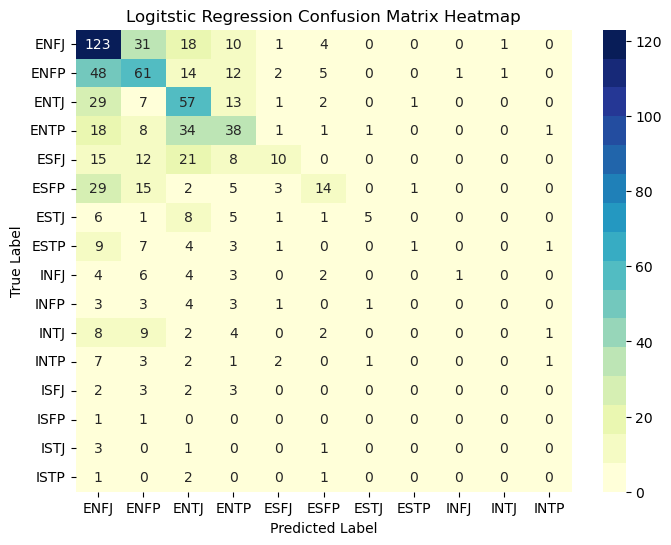

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
confusion_matrix = pd.pivot_table(lr, values='count', index='label', columns='prediction', fill_value=0)
color_list=['#ffffd9', '#f5fbc4', '#eaf7b1', '#d6efb3', '#bde5b5', '#97d6b9', '#73c8bd', '#52bcc2', '#37acc3', '#2498c1', '#1f80b8', '#2165ab', '#234da0', '#253795', '#172978', '#081d58']
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(confusion_matrix, annot=True, cmap=sns.color_palette(color_list), fmt='g', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
heatmap.set_yticklabels([label_map[label] for label in confusion_matrix.index], rotation=0)
heatmap.set_xticklabels([label_map[label] for label in confusion_matrix.columns], rotation=0)
plt.title('Logitstic Regression Confusion Matrix Heatmap')
plt.savefig("../data/plots/LR_confusion_matrix.png")
plt.show()

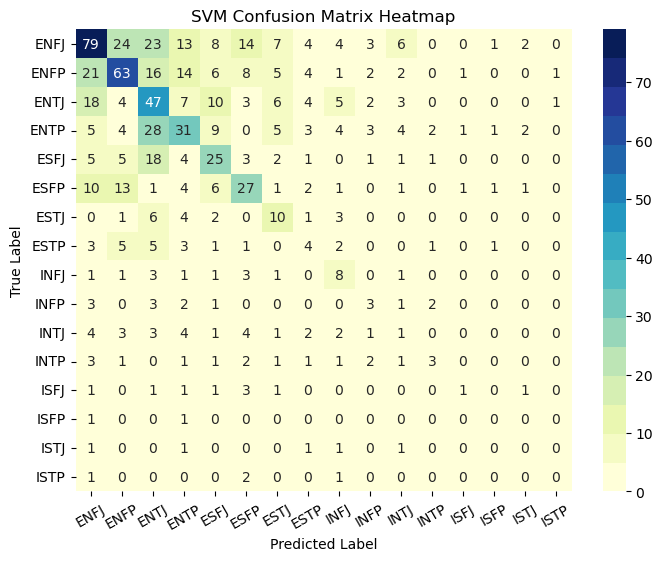

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
confusion_matrix = pd.pivot_table(ovr, values='count', index='label', columns='prediction', fill_value=0)

color_list=['#ffffd9', '#f5fbc4', '#eaf7b1', '#d6efb3', '#bde5b5', '#97d6b9', '#73c8bd', '#52bcc2', '#37acc3', '#2498c1', '#1f80b8', '#2165ab', '#234da0', '#253795', '#172978', '#081d58']
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(confusion_matrix, annot=True, cmap=sns.color_palette(color_list), fmt='g', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
heatmap.set_yticklabels([label_map[label] for label in confusion_matrix.index], rotation=0)
heatmap.set_xticklabels([label_map[label] for label in confusion_matrix.columns], rotation=30)
plt.title('SVM Confusion Matrix Heatmap')
plt.savefig("../data/plots/SVM_confusion_matrix.png")
plt.show()

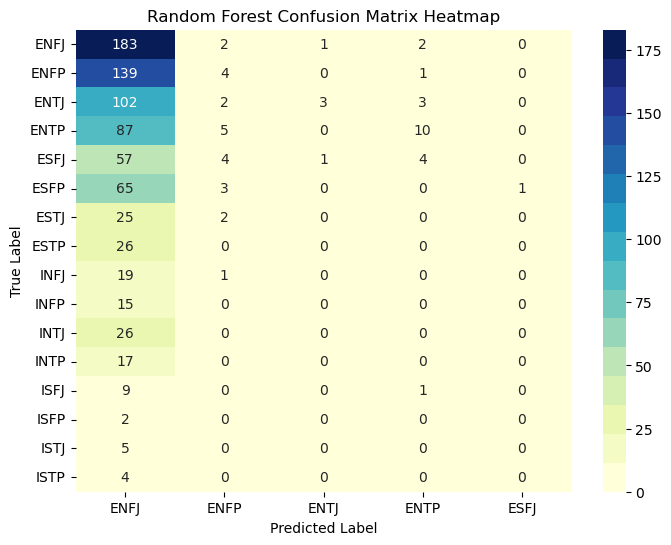

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
confusion_matrix = pd.pivot_table(rf, values='count', index='label', columns='prediction', fill_value=0)
#deine a color list
color_list=['#ffffd9', '#f5fbc4', '#eaf7b1', '#d6efb3', '#bde5b5', '#97d6b9', '#73c8bd', '#52bcc2', '#37acc3', '#2498c1', '#1f80b8', '#2165ab', '#234da0', '#253795', '#172978', '#081d58']
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(confusion_matrix, annot=True, cmap=sns.color_palette(color_list), fmt='g', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
heatmap.set_yticklabels([label_map[label] for label in confusion_matrix.index], rotation=0)
heatmap.set_xticklabels([label_map[label] for label in confusion_matrix.columns], rotation=0)
plt.title('Random Forest Confusion Matrix Heatmap')
plt.savefig("../data/plots/RF_confusion_matrix.png")
plt.show()